In [15]:
#import Pkg; Pkg.add("CSV")
#import Pkg; Pkg.add("DifferentialEquations")
#import Pkg; Pkg.add("Plots")
#import Pkg; Pkg.add("DataFrames")
using CSV
using DelimitedFiles
using DifferentialEquations
using DataFrames
import Plots: plot, hline!, scatter!

In [16]:
"""
initial conditions for new thyrosim model
"""
function initialize(
    dial::Vector{Float64} = [1.0; 0.88; 1.0; 0.88],
    scale_Vp::Bool = true,
    height=1.70,
    weight=70,
    sex=true; #true = male, false = female,
        fitting_index::Vector = Int[],         # needed in fitting
        p_being_optimized::Vector = Float64[], # needed in fitting
    fixed_parameters::Vector{Tuple{Int, Float64}}, # (a, b) means fix p[a] at b 
    scale_plasma_ode::Bool = true,
    scale_clearance_by_gender::Bool = true,
    )

    # initial conditions
    ic    = zeros(Float64, 19)
    ic[1] = 0.322114215761171
    ic[2] = 0.201296960359917
    ic[3] = 0.638967411907560
    ic[4] = 0.00663104034826483
    ic[5] = 0.0112595761822961
    ic[6] = 0.0652960640300348
    ic[7] = 1.78829584764370
    ic[8] = 7.05727560072869
    ic[9] = 7.05714474742141
    ic[10] = 0
    ic[11] = 0
    ic[12] = 0
    ic[13] = 0
    ic[14] = 3.34289716182018
    ic[15] = 3.69277248068433
    ic[16] = 3.87942133769244
    ic[17] = 3.90061903207543
    ic[18] = 3.77875734283571
    ic[19] = 3.55364471589659

    # Parameter values
    p = zeros(Float64, 100)
    p[1] = 0.0027785399344 #S4 (fitted)
    p[2] = 8               #tau
    p[3] = 0.868           #k12
    p[4] = 0.108           #k13
    p[5] = 584             #k31free
    p[6] = 1503            #k21free
    p[7] = 0.000289        #A
    p[8] = 0.000214        #B
    p[9] = 0.000128        #C
    p[10] = -8.83*10^-6    #D
    p[11] = 0.88           #k4absorb; originally 0.881
    p[12] = 0.0189         #k02
    p[13] = 0.012101809339 #VmaxD1fast (fitted)
    p[14] = 2.85           #KmD1fast
    p[15] = 6.63*10^-4     #VmaxD1slow
    p[16] = 95             #KmD1slow
    p[17] = 0.00074619     #VmaxD2slow
    p[18] = 0.075          #KmD2slow
    p[19] = 3.3572*10^-4   #S3
    p[20] = 5.37           #k45
    p[21] = 0.0689         #k46
    p[22] = 127            #k64free
    p[23] = 2043           #k54free
    p[24] = 0.00395        #a
    p[25] = 0.00185        #b
    p[26] = 0.00061        #c
    p[27] = -0.000505      #d
    p[28] = 0.88           #k3absorb
    p[29] = 0.184972339613 #k05 (fitted)
    p[30] = 450            #Bzero (fixed so max TSH is about 1000)
    p[31] = 219.7085301388 #Azero (fitted)
    p[32] = 0              #Amax (set to 0 because 1976 weeke says hypothyroid patients should have no oscillations)
    p[33] = -3.71          #phi
    p[34] = 0.53           #kdegTSH-HYPO
    p[35] = 0.226          #VmaxTSH (originally it's 0.037 but this is probably a typo because eq4 of 2010 eigenberg it not a real hill function)
    p[36] = 23             #K50TSH
    p[37] = 0.058786935033 #k3 (fitted)
    p[38] = 0.29           #T4P-EU
    p[39] = 0.006          #T3P-EU
    p[40] = 0.037          #KdegT3B
    p[41] = 0.0034         #KLAG-HYPO
    p[42] = 5              #KLAG
    p[43] = 1.3            #k4dissolve
    p[44] = 0.12           #k4excrete; originally 0.119 (change with dial 2)
    p[45] = 1.78           #k3dissolve
    p[46] = 0.12           #k3excrete; originally 0.118 (change with dial 4)
    p[47] = 3.2            #Vp
    p[48] = 5.2            #VTSH 

    #parameters for hill functions in f_circ and SRtsh
    p[49] = 3.001011022378 #K_circ (fitted)
    p[50] = 3.094711690204 #K_SR_tsh (fitted)
    p[51] = 5.674773816316 #n, hill exponent in f_circ (fitted)
    p[52] = 6.290803221796 #m, hill exponent in SR_tsh (fitted)
    p[53] = 8.498343729591 #K_f4 for f4 (fitted)
    p[54] = 14.36664496926 #l, hill exponent for f4 (fitted)

    # Initialize LT4 and LT3 dosages - 09/11/25
    p[55] = 0.0 # T4 oral dose
    p[56] = 0.0 # T3 oral dose

    # dial parameters 
    p[57] = dial[1] # controls T4 secretion rate
    p[58] = dial[2] # controls T4 absorption rate
    p[59] = dial[3] # controls T3 secretion rate
    p[60] = dial[4] # controls T3 absorption rate

    # variance parameters for T4/T3/TSH and schneider error (these are used only for parameter estimation!)
        p[61] = 5.003761571969437   # σ for T4 in Blakesley (fixed to reasonable value before fitting)
        p[62] = 0.11122955089297369 # σ for T3 Blakesley and Jonklaas (fixed to reasonable value before fitting)
        p[63] = 0.4                 # σ for TSH in Blakesley and Jonklaas (fixed to reasonable value before fitting)
        p[64] = 0.1                 # σ for FT4 in Jonklaas (fixed to reasonable value before fitting)

    # Blakesley reference BMI
        p[65] = 21.82854404275587 # (male, fitted)
        p[66] = 22.99050845201536 # w / h^2 (female, fitted)

    # Vtsh scaling factor
    p[67] = 1.0 

    # Volume scaling ratio
    p[69] = 1.0 # Plasma volume ratio
    p[71] = 1.0 # no non-unity allometric exponent for plasma volume 09/11/25

        # slow and fast compartment scaling ratios should not be needed, deleted 09/11/25
        # allometric exponent for k05 - no longer needed 09/11/25

    # ref height for male and female
    p[78] = 1.7608716659237555 # (fitted)
    p[79] = 1.6696106891941103 # (fitted)

    # clearance scale (male / female)
    p[80] = 1.0499391485135692 # male clearance (fitted)

    # Initialize infusion parameters
    p[81] = 0.0 # T4 infusion
    p[82] = 0.0 # T3 infusion

        # change fitting parameters
        if length(fitting_index) > 0
            p[fitting_index] .= p_being_optimized
        end

        # scale plasma parameters
        ref_bmi = sex ? p[65] : p[66]
    
    # (Seems like reference_Vp is needed in the code 09/11/25)
    if scale_plasma_ode
        # for now, assume male and females have the same ref Vp (ie average male/female ref Vp)
        ref_Vp = (reference_Vp(ref_bmi, true, p[78]) + reference_Vp(ref_bmi, false, p[79])) / 2
        p[69] = predict_Vp(height, weight, sex) / ref_Vp
    end
    
    
    
        # We have removed allometric scaling 09/11/25
        # scale slow compartment - we have removed this 09/11/25
        # scale fast compartment - we have removed this 09/11/25


    if scale_Vp
        Vp, Vtsh = plasma_volume(height, weight, sex, p[67], ref_bmi, p[78], p[79])
        p[47] = Vp
        p[48] = Vtsh
    end
    
    
    # Making K05 a function of sex - Katarina
    p29_original = p[29]

    if sex  # male
        p[29] = p29_original * p[80]
    else    # female
        p[29] = p29_original
    end


        # fix parameters declared by users
        for (a, b) in fixed_parameters
            p[a] = b
        end


        return ic, p, p[48]  # return Vtsh explicitly
end

# BEN's Explanation of how he computed Vp. Our code should override his code for this. 09/11/25
"""
    plasma_volume(height, weight, sex, p)

# Parameters used to get reference plasma volume (Vp) values:
## MCL: NEED TO DOUBLE-CHECK HEIGHT/WEIGHT
## Blakesley data: half male, half female all of "normal weight and height" (but no values given in paper).
## height: Average height in USA.
## weight: I think we used approximate values from back-transforming it from BMI = 22.5?
    male_height   = 1.70
    female_height = 1.63
    male_weight   = 70.0
    female_weight = 59.0

The transform equation is `Vp_new = 3.2 * Vp_predicted / Vp_ref` where `Vp_ref` is 
the predicted Vp for the reference male/female patients. Thus, a reference
patient would have Vp_new = 3.2.

# Inputs
+ `h`: height measured in meters
+ `w`: weight measured in KG 
+ `sex`: true = male, false = female

# Optional inputs
+ `male_ref_vp`: male reference Vp
+ `female_ref_vp`: female reference Vp

# Outputs 
+ `Vp_new`: Scaled plasma volume (liters)
+ `Vtsh_new`: Scaled TSH distribution volume (liters)
"""

# We need the following code for our new Vp estimates - 09/11/25
# Predict_Vp is computed anew subsequently - 09/11/25

function plasma_volume(h, w, sex::Bool,
    Vtsh_scale = 1.0, ref_bmi = 22.5,
    male_ref_height = 1.7, female_ref_height=1.63
    )
    # for now, assume male and females have the same ref Vp (ie average male/female ref Vp)
    ref_Vp = (reference_Vp(ref_bmi, true, male_ref_height) + reference_Vp(ref_bmi, false, female_ref_height)) / 2
    Vp_new = predict_Vp(h, w, sex) * 3.2 / ref_Vp

    # scale Vtsh according to Vtsh_new = Vtsh_old + c(Vp_new - Vp_old) 
    Vtsh_new = 5.2 + Vtsh_scale * (Vp_new - 3.2)  # changed 5.2 to Vtsh= = p[48] - KATARINA 08/18/25

    return Vp_new, Vtsh_new
end

# BEN's explanatation of reference_Vp
"""
        reference_Vp(ref_BMI::Float64, sex::Bool)

    Calculates the "reference plasma volume" for Blakesleys patients with specified

    Since the predicted plasma volume from Feldschush's data is not 3.2, this
    reference volume is used to scale the predicted volume to 3.2. 
"""
function reference_Vp(ref_BMI::Float64, sex::Bool, ref_height::Float64)
    # calculate weight for specified ref_BMI. Ideal weight (iw) is fitted to Feldschush's data
    if sex
        iw = 176.3 - 220.6 * ref_height + 93.5 * ref_height^2
    else
        iw = 145.8 - 182.7 * ref_height + 79.55 * ref_height^2
    end
    w = ref_BMI * ref_height^2

    return predict_Vp(ref_height, w, sex)
end


"""
    predict_Vp(h, w, sex::Bool)

Computes the predicted plasma volume based on data fitted to Feldchush's blood data

# Inputs
+ `h`: height measured in meters
+ `w`: weight measured in KG 
+ `sex`: true = male, false = female
"""

# new fit equations below instead of Ben's - KATARINA 08/18/25
    # Male: Vb_per_kg = 71.96 * exp(-0.007516 * Δiw)
    # Female: Vb_per_kg = 43.65 + 20.79 * exp(-0.01545 * Δiw) + 2.043 * exp(-0.08392 * Δiw)

function predict_Vp(h, w, sex::Bool)  # KATARINA 08/18/25
    # Hematocrit level: 0.45 for male, 0.40 for female
    Hem = 0.40 + 0.05 * sex

    if sex == 1
       iw = 176.3 - 220.6 * h + 93.5 * h^2
    elseif sex == 0
       iw = 145.8 - 182.7 * h + 79.55 * h^2
    end

    # Percent deviation from ideal weight
    Δiw = (w - iw) / iw * 100

    
    if sex == 1
       Vb_per_kg = 71.96 * exp(-0.007516 * Δiw)
    elseif sex == 0
       Vb_per_kg = 43.65 + 20.79 * exp(-0.01545 * Δiw) + 2.043 * exp(-0.08392 * Δiw)
    end

    # Compute total blood volume in liters
    Vb = Vb_per_kg * w / 1000

    # Return plasma volume (liters)
    return Vb * (1 - Hem) # = Vp
end





"""
ODEs for Ben's pthyrosim model. 
"""
function thyrosim(dq, q, p, t)
    kdelay = 5/8

    # scaling the mass/concentration of compartments (Ben previously scaled these with non-1's. 
    # Haven't figured out why yet - 09/11/25)
    plasma_volume_ratio = p[69]^p[71]
    
    # Slow and fast volume ratios are 1 and were taken out of the ODEs - 09/11/25

    # scale compartment sizes
    q1 = q[1] * 1 / p[69]
    q2 = q[2] * 1 
    q3 = q[3] * 1 
    q4 = q[4] * 1 / p[69]
    q5 = q[5] * 1 
    q6 = q[6] * 1 
    q7 = q[7] * 1 / p[69]

    # adhoc fix for https://github.com/biona001/Thyrosim.jl/issues/1
    q[findall(x -> x < 0, q)] .= 0

    # Auxillary equations
    q4F = (p[24]+ p[25] * q1 + p[26] * q1^2 + p[27] * q1^3) * q4 #FT3p
    q1F = (p[7] + p[8] * q1 + p[9] * q1^2 + p[10] * q1^3) * q1  #FT4p
    SR3 = (p[19] * p[59] * q[19])                                        #Brain delay (dial 3)
    SR4 = (p[1] * p[57] * q[19])                                         #Brain delay (dial 1)
    fCIRC = q[9]^p[51] / (q[9]^p[51] + p[49]^p[51])
    SRTSH = (p[30]+p[31]*fCIRC*sin(pi/12*t-p[33]))*(p[50]^p[52]/(p[50]^p[52] + q[9]^p[52]))
    fdegTSH = p[34] + p[35] / (p[36] + q7)
    fLAG = p[41] + 2*q[8]^11 / (p[42]^11 + q[8]^11)
    f4 = p[37]*(1 + 5*(p[53]^p[54]) / (p[53]^p[54]+q[8]^p[54]))
    NL = p[13] / (p[14] + q2)

    # Ben's ODEs include plasma, fast, and slow volume ratios. We don't know why yet, but the code won't 
    # run correctly if we take out plasma volume ratio, even though we set the exponents equal to 1, p[71] this
    # means that Ben's averaging of male and female Vp's is included in our code too. Not sure we need it, but...
    # 09/11/25
    
    # ODEs
    dq[1]  = p[81] + (SR4 + p[3] * q2 + p[4] * q3 - (p[5] + p[6]) * q1F) * plasma_volume_ratio + p[11] * q[11] #T4dot (need to remove u1)
    dq[2]  = (p[6] * q1F - (p[3] + p[12] + NL) * q2)                                     #T4fast
    dq[3]  = (p[5] * q1F -(p[4] + p[15] / (p[16] + q3) + p[17] /(p[18] + q3)) * q3)   #T4slow
    dq[4]  = p[82] + (SR3 + p[20] * q5 + p[21] * q6 - (p[22] + p[23]) * q4F) * plasma_volume_ratio + p[28] * q[13] #T3pdot
    dq[5]  = (p[23] * q4F + NL * q2 - (p[20] + p[29]) * q5)                         #T3fast
    dq[6]  = (p[22] * q4F + p[15] * q3 / (p[16] + q3) + p[17] * q3 / (p[18] + q3) -(p[21])*q6)  #T3slow
    dq[7]  = (SRTSH - fdegTSH * q7) * plasma_volume_ratio                                  #TSHp
    dq[8]  = f4 / p[38] * q1 + p[37] / p[39] * q4 - p[40] * q[8]          #T3B
    dq[9]  = fLAG * (q[8] - q[9])                                             #T3B LAG
    dq[10] = -p[43] * q[10]                                                   #T4PILLdot
    dq[11] =  p[43] * q[10] - (p[44] * p[58]+ p[11]) * q[11]                  #T4GUTdot: note p[44] * p[58] = p[44] * dial[2] = k4excrete
    dq[12] = -p[45] * q[12]                                                   #T3PILLdot
    dq[13] =  p[45] * q[12] - (p[46] * p[60] + p[28]) * q[13]                 #T3GUTdot: note p[46] * p[60] = p[46] * dial[4] = k3excrete

    # Delay ODEs
    dq[14] = kdelay * (q7 - q[14]) 
    dq[15] = kdelay * (q[14] - q[15])                                         #delay2
    dq[16] = kdelay * (q[15] - q[16])                                         #delay3
    dq[17] = kdelay * (q[16] - q[17])                                         #delay4
    dq[18] = kdelay * (q[17] - q[18])                                         #delay5
    dq[19] = kdelay * (q[18] - q[19])                                         #delay6
end

function output_equations(sol, p)
    return [777.0 * sol[1, :] / p[47], #T4
            651.0 * sol[4, :] / p[47], #T3
            5.6 * sol[7, :] / p[48]] #TSH
end




"""
Set initial conditions from data. First steady state paragraph are FT4 and FT3 algebraic equations. 
Options to set other compartments to steady state, optionally including the TSH lag compartments.
"""
function set_patient_ic!(ic, p, t4, t3, tsh;
        steady_state::Bool=false, set_tsh_lag::Bool=false)
    # Set IC for observed compartments. 
    ic[1] = (p[47] * t4) / 777.0
    ic[4] = (p[47] * t3) / 651.0
    ic[7] = (p[48] * tsh) / 5.6
    
    if steady_state
        q4F = (p[24]+ p[25] * ic[1] + p[26] * ic[1]^2 + p[27] *ic[1]^3) * ic[4] #FT3p
        q1F = (p[7] + p[8] * ic[1] + p[9] * ic[1]^2 + p[10] * ic[1]^3) * ic[1]  #FT4p
        
        B = p[6] * q1F - p[14] * (p[3] + p[12]) - p[13]
        A = -(p[3] + p[12])
        C = p[6] * p[14] * q1F
        ic[2] = (-B - sqrt(B^2 - 4.0 * A *C)) / (2.0 * A)
        
        B = p[5] * q1F - (p[4] + p[15] / p[16]) * p[18] - p[17]
        A = -(p[4] + p[15] / p[16])
        C = p[5] * p[18] * q1F
        ic[3] = (-B - sqrt(B^2 - 4.0 * A *C)) / (2.0 * A)
        
        ic[5] = (p[23] * q4F + (p[13] / (p[14] + ic[2])) * ic[2]) / (p[20] + p[29])
        ic[6] = (p[22] * q4F + p[15] * (ic[3] / (p[16] + ic[3]))
            + p[17] * (ic[3] / (p[18] + ic[3]))) / p[21]
    end
    
    if set_tsh_lag
        # Probably ok.
        ic[14:19] .= ic[7]
    end
end


"""
Find initial conditions from approximate steady state solution. 

This function runs a Thyrosim simulation for 30 days and sets the initial 
contidion `ic` to the ending values for each compartment.
"""
function find_patient_ic!(ic, p, days, model = thyrosim)
    tspan = (0.0, 24.0 * days)
    prob = ODEProblem(model, ic, tspan, p)
    sol = solve(prob)
    ic .= sol[end]
end


# Deleted the section on adipose tissue and fat free mass scaling and organs (liver and kidney) - 09/11/25

find_patient_ic!

In [17]:
"""
    simulate(h, w, sex, ...)

Simulate a person of known height, weight, and gender for 30 days (default).

If `warmup = true`, will first run the model for 30 days, assuming healthy
thyroid function, to get approximate initial condition. 

Note: The last 5 parameters are optional scaling parameters, but in our final model,
only `scale_plasma_ode` and `scale_clearance_by_gender` are set to `true`. Thus only 
these 2 are true by default. 
"""
function simulate(
    h::Real, # units meters
    w::Real, # units kg
    sex::Bool; # true = male, false = female
    days::Int=30, 
    dial=[1.0; 0.88; 1.0; 0.88], 
    T4dose::Real=0.0, # mcgs
    T3dose::Real=0.0, # mcgs
    dosing_interval::Real=24.0, #hours
    warmup::Bool = true,
    fitting_index = Int[],
    parameters = Float64[],
    fixed_parameters=Tuple{Int64,Float64}[],
    scale_plasma_ode=true,
    scale_clearance_by_gender = true,
    )
    function add_dose!(integrator)
        integrator.u[10] += integrator.p[55]
        integrator.u[12] += integrator.p[56]
    end
    cbk = PeriodicCallback(add_dose!, dosing_interval) 

    # initialize thyrosim parameters
    ic, p = initialize(dial, true, h, w, sex, 
        fitting_index=fitting_index, p_being_optimized=parameters,
        fixed_parameters=fixed_parameters,
        scale_plasma_ode=scale_plasma_ode,
        scale_clearance_by_gender=scale_clearance_by_gender)
    p[fitting_index] .= parameters

    # run simulation for 30 days to get approximate steady state conditions
    # this assumes healthy patient without dose
    warmup && find_patient_ic!(ic, p, 30) 

    # setup daily dosing and fitting parameters 
    p[55] = T4dose / 777.0 # daily dose
    p[56] = T3dose / 651.0 # daily dose
    p[57:60] .= dial #set dial

    # solve and return ode solution
    prob = ODEProblem(thyrosim,ic,(0.0, 24days),p,callback=cbk)
    return solve(prob, Rodas5())
end

simulate

In [18]:
using Plots
using DifferentialEquations

# KATARINA - created dosing plot functions for either FT4/FT3/TSH, FT4/TT3/TSH or TT4/TT3/TSH

function dosing_plots_FT4_FT3_TSH(sol; title::AbstractString = "Thyrosim simulation", automargins::Bool=true)
    p = sol.prob.p
    
    # Correct conversion equations
    T4 = sol[1,:]
    T3 = sol[4,:]
    
    # FT4 and FT3 are slightly adjusted upwards for changes in assay methods over the last several decades.
    # Mean values adjusted to the middle of 2025 normal clinical lab ranges. - KAT/JOE 
    FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
    FT3 = 1.05 * 0.5 * (0.00395 .+ 0.00185 .* T4 .+ 0.00061 .* T4.^2 .+ 0.000505 .* T4.^3) .* T3

    FT4_units = 1000 * 777 .* FT4 ./ p[47]      # ng/L
    FT3_units = 1000 * 651 .* FT3 ./ p[47]      # ng/L
    TSH = 5.6 * sol[7, :] / p[48]
    
    if automargins
        ft4lim = max(1.2 * maximum(FT4), 2)
        ft3lim = max(1.2 * maximum(FT3), 0.0044)
        tshlim = max(1.2 * maximum(TSH), 5.5)
    end

    p1 = plot(sol.t / 24.0, FT4_units, ylabel="FT4 (ng/L)", title=title, linewidth=2, legend=false)
    p1 = hline!([8, 18])

    p2 = plot(sol.t / 24.0, FT3_units, ylabel="FT3 (ng/L)", linewidth=2, legend=false)
    p2 = hline!([2.25, 4])

    p3 = plot(sol.t / 24.0, TSH, ylabel="TSH (mU/L)", xlabel="Days", linewidth=2, legend=false)
    p3 = hline!([0.4, 4.0])

    plot(p1, p2, p3, layout=(3, 1))
end

    
function dosing_plots_FT4_TT3_TSH(sol; title::AbstractString = "Thyrosim simulation", automargins::Bool=true)
    p = sol.prob.p
    T4 = sol[1, :]
    T3 = sol[4, :]
    TSH = 5.6 * sol[7, :] / p[48]

    FT4 = 1.1 * 0.45 * (0.000289 .+ 0.000214 .* T4 .+ 0.000128 .* T4.^2 .- 8.83e-6 .* T4.^3) .* T4
    FT4_units = 1000 * 777 .* FT4 ./ p[47]
    TT3 = 651.0 * T3 ./ p[47]

    ft4lim, tt3lim, tshlim = 25.0, 3.0, 10.0
    if automargins
        ft4lim = max(1.2 * maximum(FT4_units), 18)
        tt3lim = max(1.2 * maximum(TT3), 2.0)
        tshlim = max(1.2 * maximum(TSH), 5.5)
    end

    p1 = plot(sol.t / 24.0, FT4_units, ylabel="FT4 (ng/L)", title=title, linewidth=2, legend=false)
    p1 = hline!([8, 18])

    p2 = plot(sol.t / 24.0, TT3, ylim=(0, tt3lim), ylabel="TT3 (µg/L)", linewidth=2, legend=false)
    p2 = hline!([0.6, 1.8])

    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), ylabel="TSH (mU/L)", xlabel="Days", linewidth=2, legend=false)
    p3 = hline!([0.45, 4.5])

    plot(p1, p2, p3, layout=(3, 1))
end

dosing_plots_FT4_TT3_TSH (generic function with 1 method)

In [19]:
# Conversion functions
function inches_to_meters(inches)
    return inches * 0.0254
end

function pounds_to_kilograms(pounds)
    return pounds * 0.453592
end
  
    
# New function that allows for 24 hour dosing intervals of LT4 and 12 hour dosing intervals of LT3
function simulate_dosing_intervals(
    h::Real, w::Real, sex::Bool;
    days::Int=30, 
    dial=[1.0; 0.88; 1.0; 0.88], 
    T4dose::Real=0.0, 
    T3dose::Real=0.0, 
    warmup::Bool=true,
    fitting_index=Int[],
    parameters=Float64[],
    fixed_parameters=Tuple{Int64,Float64}[],
    scale_plasma_ode=true,
    scale_clearance_by_gender=true,
)
    # Callback to add LT4 every 24 hours
    function add_LT4!(integrator)
        integrator.u[10] += integrator.p[55]
    end
    cbk_LT4 = PeriodicCallback(add_LT4!, 24.0)

    # Callback to add LT3 every 12 hours
    function add_LT3!(integrator)
        integrator.u[12] += integrator.p[56]
    end
    cbk_LT3 = PeriodicCallback(add_LT3!, 12.0)

    # Initialize
    ic, p = initialize(dial, true, h, w, sex, fitting_index=fitting_index, p_being_optimized=parameters,
        fixed_parameters=fixed_parameters, scale_plasma_ode=scale_plasma_ode, 
        scale_clearance_by_gender=scale_clearance_by_gender)
    p[fitting_index] .= parameters

    warmup && find_patient_ic!(ic, p, 30)

    p[55] = T4dose / 777.0  
    p[56] = T3dose / 651.0  
    p[57:60] .= dial  

    # Create the problem with both callbacks in a CallbackSet
    prob = ODEProblem(thyrosim, ic, (0.0, days*24), p, callback=CallbackSet(cbk_LT4, cbk_LT3))

    return solve(prob)
end


simulate_dosing_intervals (generic function with 1 method)

# Generate Plots

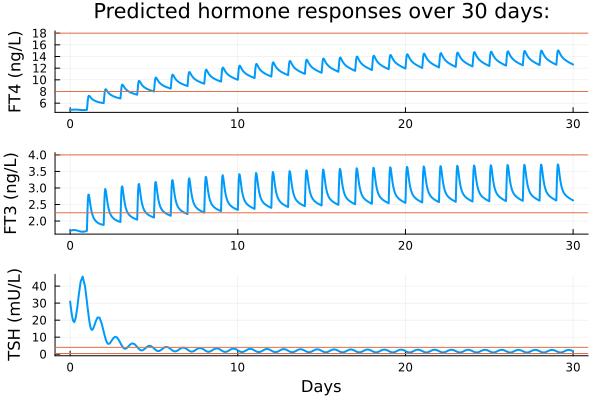

In [20]:
# Example 1: Female, 67 in, 120 lbs, RTF = 2.5%, given LT4 dose of 100 µg and 7.5 µg LT3 every 24 hours
# Plotted on FT4, FT3, TSH plots

# === INPUTS (Imperial units) ===
sex = false                 # true = Male, false = Female
h_in = 67                   # Height in inches
w_lb = 120                  # Weight in pounds
T4dose = 100               # LT4 dose in µg
T3dose = 7.5                  # LT3 dose in µg
RTF = 0.025                 # Residual thyroid function (0–1)
dial = [RTF; 0.88; RTF; 0.88] # Thyroid secretion rates (stays constant)

# === Convert to metric units ===
h_m = inches_to_meters(h_in)
w_kg = pounds_to_kilograms(w_lb)

# === RUN SIMULATION ===
# 24-hr dosing intervals of LT4 + LT3
sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose)

# 24-hr dosing interval of LT4 and 12-hr dosing interval of LT3
#sol = simulate_dosing_intervals(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose) 


# === PLOT RESULTS ===
plt = dosing_plots_FT4_FT3_TSH(sol, title="Predicted hormone responses over 30 days:") # Plots FT4, FT3, TSH
#plt = dosing_plots_FT4_TT3_TSH(sol, title="Predicted hormone responses over 30 days:") # Plots FT4, TT3, TSH
#plt = dosing_plots_TT4_TT3_TSH(sol, title="Predicted hormone responses over 30 days:") # Plots TT4, TT3, TSH


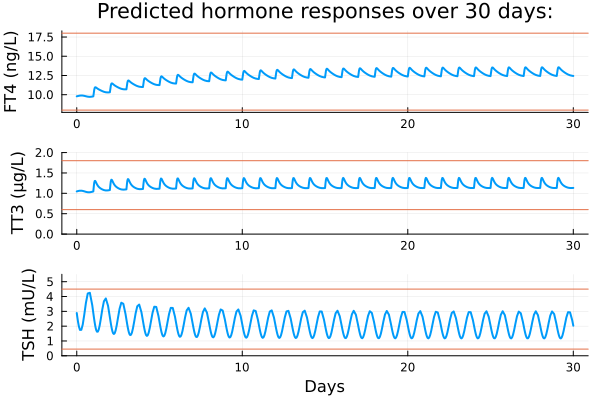

In [21]:
# Example 2: Male, 70 in, 160 lbs, RTF = 50%, given LT4 dose of 50 µg and 5 µg LT3 every 24 hours
# Plotted on FT4, TT3, TSH plots

# === INPUTS (Imperial units) ===
sex = true                  # true = Male, false = Female
h_in = 70                   # Height in inches
w_lb = 160                  # Weight in pounds
T4dose = 50                 # LT4 dose in µg
T3dose = 5                  # LT3 dose in µg
RTF = 0.5                  # Residual thyroid function (0–1)
dial = [RTF; 0.88; RTF; 0.88] # Thyroid secretion rates (stays constant)

# === Convert to metric units ===
h_m = inches_to_meters(h_in)
w_kg = pounds_to_kilograms(w_lb)

# === RUN SIMULATION ===
# 24-hr dosing intervals of LT4 + LT3
sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose)

# 24-hr dosing interval of LT4 and 12-hr dosing interval of LT3
#sol = simulate_dosing_intervals(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose) 


# === PLOT RESULTS ===
#plt = dosing_plots_FT4_FT3_TSH(sol, title="Predicted hormone responses over 30 days:") # Plots FT4, FT3, TSH
plt = dosing_plots_FT4_TT3_TSH(sol, title="Predicted hormone responses over 30 days:") # Plots FT4, TT3, TSH
#plt = dosing_plots_TT4_TT3_TSH(sol, title="Predicted hormone responses over 30 days:") # Plots TT4, TT3, TSH


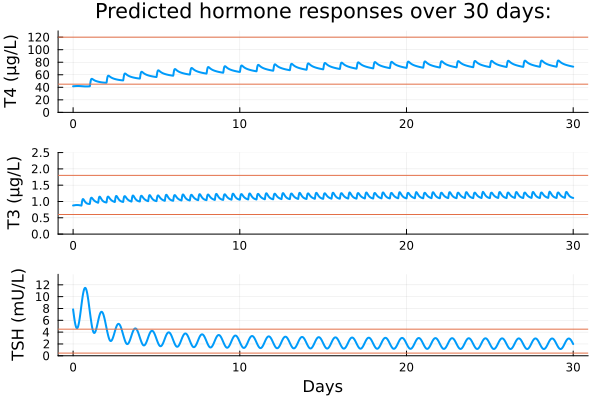

In [22]:
# Dosing plots TT4, TT3, TSH

function dosing_plots_TT4_TT3_TSH(sol; title::AbstractString = "Thyrosim simulation", automargins::Bool=true)
    p = sol.prob.p 
    t4lim, t3lim, tshlim = 140, 4, 10
    T4 = 777.0 * sol[1, :] / p[47]
    T3 = 651.0 * sol[4, :] / p[47]
    TSH = 5.6 * sol[7, :] / p[48]
    
    if automargins
        t4lim = max(1.2 * maximum(T4), 130.0)
        t3lim = max(1.2 * maximum(T3), 2.5)
        tshlim = max(1.2 * maximum(TSH), 5.5)
    end

    p1 = plot(sol.t / 24.0, T4, ylim=(0, t4lim), ylabel="T4 (µg/L)", title=title, linewidth=2, legend=false)
    p1 = hline!([45, 120])

    p2 = plot(sol.t / 24.0, T3, ylim=(0, t3lim), ylabel="T3 (µg/L)", linewidth=2, legend=false)
    p2 = hline!([0.6, 1.8])

    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), ylabel="TSH (mU/L)", xlabel="Days", linewidth=2, legend=false)
    p3 = hline!([0.45, 4.5])

    plot(p1, p2, p3, layout=(3, 1))
end

    
    
# Example 3: Male, 77 in, 200 lbs, RTF = 15%, given LT4 dose of 112.5 µg every 24 hrs and 7.5 µg LT3 every 12 hours
# Plotted on TT4, TT3, TSH plots

# === INPUTS (Imperial units) ===
sex = true                  # true = Male, false = Female
h_in = 77                   # Height in inches
w_lb = 200                 # Weight in pounds
T4dose = 137.5                 # LT4 dose in µg
T3dose = 5                  # LT3 dose in µg
RTF = 0.15                   # Residual thyroid function (0–1)
dial = [RTF; 0.88; RTF; 0.88] # Thyroid secretion rates (stays constant)

# === Convert to metric units ===
h_m = inches_to_meters(h_in)
w_kg = pounds_to_kilograms(w_lb)

# === RUN SIMULATION ===
# 24-hr dosing intervals of LT4 + LT3
#sol = simulate(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose)

# 24-hr dosing interval of LT4 and 12-hr dosing interval of LT3
sol = simulate_dosing_intervals(h_m, w_kg, sex, dial=dial, T4dose=T4dose, T3dose=T3dose) 


# === PLOT RESULTS ===
#plt = dosing_plots_FT4_FT3_TSH(sol, title="Predicted hormone responses over 30 days:") # Plots FT4, FT3, TSH
#plt = dosing_plots_FT4_TT3_TSH(sol, title="Predicted hormone responses over 30 days:") # Plots FT4, TT3, TSH
plt = dosing_plots_TT4_TT3_TSH(sol, title="Predicted hormone responses over 30 days:") # Plots TT4, TT3, TSH
